# Quantitatively, do TMDLs spur limit changes?

Author: Ryan Treves

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import seaborn as sns
from datetime import timedelta
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Set file path for loading data
data_path = 'data/'

# Load ATTAINS data
tmdls = pd.read_csv(data_path + 'all_actions.csv', parse_dates=['completionDate', 'TMDLDate'],
                    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(
    columns={'assessmentUnitIdentifier': 'AUID'})
tmdl_permit_links = pd.read_csv(data_path + 'all_actions_permit_data.csv').rename(
    columns={'NPDESIdentifier': 'npdes_permit_id'})

# Load RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier': 'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv(data_path + 'huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(
    columns={'attributes.assessmentunitidentifier': 'AUID', 'attributes.huc12': 'HUC-12'})

# Load ICIS-NPDES data:
# Load prepped DMR dataset of DMRs from all NPDES permit limits subject to permit limit changes
# (see https://github.com/ryantreves/dmr-permit-limit-changes/blob/main/preprocessing/__init__.py
# and https://github.com/ryantreves/dmr-permit-limit-changes/blob/main/national_exploratory_analysis.ipynb
# for details on how this .csv was created)
prepped_dmrs = pd.read_csv(
    '/Users/rtreves/Documents/RegLab/python_projects/dmr_permit_limit_changes/all_prepped.csv',
    parse_dates=['limit_begin_date', 'limit_end_date', 'limit_change_date'],
    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).dropna(subset='limit_value_standard_units')
# Load permit data
permit_data = pd.read_csv('data/permit_data.csv',
                          parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date',
                                       'expiration_date', 'retirement_date', 'termination_date'],
                          date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

First, let's link TMDLs to NPDES permittees:

In [3]:
# Filter out TMDLs categorized as exclusively Nonpoint source
tmdls = tmdls[tmdls['pollutantSourceTypeCode'] != 'Nonpoint source']

# Link TMDLs to HUC-12 codes to NPDES permittees. This is our 'geospatial' linkage.
tmdls_merged = tmdls.drop_duplicates().merge(HUC_AUID_links, on='AUID', how='inner').merge(HUC_npdes_permit_links,
                                                                                           on='HUC-12', how='inner')
# Because the geospatial linkage may not catch all NPDES permittees linked to TMDLs, let's take the union of the geospatial links
# and the tabular links (based on NPDES permittees explicitly mentioned in ATTAINS TMDL records):
tmdls_merged = tmdls_merged.merge(tmdl_permit_links, on=['actionIdentifier', 'npdes_permit_id'], how='outer')

# Deleting objects we no longer need to save memory
del HUC_AUID_links
del HUC_npdes_permit_links

How many TMDLs of each pollutant source type code do we have?

In [4]:
tmdls_merged.drop_duplicates('actionIdentifier')['pollutantSourceTypeCode'].value_counts()

Both            4333
Unknown          134
Point source      78
Name: pollutantSourceTypeCode, dtype: int64

Now, let's link these TMDL-NPDES permittee observations to specific NPDES permit limits. Our first challenge is to link values of `pollutantName` in the TMDLs table with values of `parameter_desc` in the DMRs table, so that we only retain limits relevant to the pollutant that was the cause of impairment.

In [5]:
# Dictionary I created linking `pollutantName` from ATTAINS to one or more values of `parameter_desc` from ICIS-NPDES.
# Essentially, I copied parameters from the list of values of `parameter_desc` in DMR Data dictionary that were
# similar or containing the value of `pollutantName` from the TMDL, minus those parameters indicating '% removed'.
# This list includes all pollutants that individually represent >1% of all TMDLs, and in total covers ~84% of all
# TMDLs in ATTAINS. I did not create a complete dictionary due to the time/return ratio for the many unique
# pollutants accounting for only a handful of TMDLs.
# Note: there is definitely some uncertainty involved in this linkage due to my lack of expertise in water chemistry
# (e.g., are there point-source parameters not related to BOD that may still contribute to water body impairment
# caused by BOD?).
pollutant_parameter_link_dict = {
    'ALUMINUM': ['Aluminum', 'Aluminum [total]', 'Aluminum chloride, dissolved, water', 'Aluminum oxide',
                 'Aluminum stearate, wat sol in drill fl', 'Aluminum sulfate',
                 'Aluminum, acid soluble', 'Aluminum, dissolved [as Al]', 'Aluminum, ion',
                 'Aluminum, potentially dissolvd', 'Aluminum, total',
                 'Aluminum, total [as Al]',
                 'Aluminum, total [as Al] [Can Production]', 'Aluminum, total recoverable',
                 'Aluminum, total sludge, dry wt.'],

    'AMMONIA': ['Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'AMMONIA-NITROGEN': ['Ammonia nitrogen, total, [as N] 30 day', 'Nitrogen, ammonia [NH3-N]',
                         'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                         'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                         'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                         'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                         'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                         'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                         'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'AMMONIA, TOTAL': ['Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                       'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'ARSENIC': ['Arsenic', 'Arsenic total, dry weight, sludge', 'Arsenic, dissolved [as As]', 'Arsenic, dry weight',
                'Arsenic, Inorganic', 'Arsenic, potentially dissolved', 'Arsenic, sludge tot. dry wt [as As]',
                'Arsenic, total [as As]', 'Arsenic, total recoverable', 'Arsenic, total recoverable',
                'Arsenic, trivalent dissolved', 'Arsenic, trivalent total', 'Arsenic, trivalent total recoverable'],

    'BIOCHEMICAL OXYGEN DEMAND (BOD)': ['Non-nitrogenous BOD', 'Carbonaceous BOD, 5 day, 20 deg C filtrd', 'BOD',
                                        'BOD 5-Day [lbs/1000 lbs Product]', 'BOD excursions', 'BOD, [ult. 1st stage]',
                                        'BOD, [ult. 2nd stage]', 'BOD, [ult. all stages]', 'BOD, % over influent',
                                        'BOD, 11-day [20 deg. C]', 'BOD, 120 Day,20 Degrees C',
                                        'BOD, 20-day [20 deg. C]', 'BOD, 20-day, percent removal',
                                        'BOD, 35-day [20 deg. C]', 'BOD, 5 day carbonaceous, % rmvl, dry',
                                        'BOD, 5 day carbonaceous, % rmvl, wet', 'BOD, 5 day percent removal, dry',
                                        'BOD, 5 day percent removal, wet', 'BOD, 5 lb/cu ft process', 'BOD, 5-day',
                                        'BOD, 5-day, 20 deg C per cfs of streamflw', 'BOD, 5-day, 20 deg. C',
                                        'BOD, 5-day, 20 deg. C', 'BOD, 5-day, 20 deg. C',
                                        'BOD, 5-day, 20 deg. C [per season]', 'BOD, 5-day, 20 deg. C per production',
                                        'BOD, 5-day, dissolved', 'BOD, 5-day, percent removal', 'BOD, 5-day, total',
                                        'BOD, carb-5 day, 20 deg C, percent removal',
                                        'BOD, carbonaceous [20 day, 20 C]', 'BOD, carbonaceous [25-day, 20 C]',
                                        'BOD, carbonaceous [28 day, 20 C]', 'BOD, carbonaceous [40 day, 20 C]',
                                        'BOD, carbonaceous [5 day, 20 C]', 'BOD, carbonaceous [5 day, 20 C][load]',
                                        'BOD, carbonaceous [5 day, 20 C][per discharge]',
                                        'BOD, carbonaceous [5 day, 5 C]', 'BOD, carbonaceous [5-day, 20 C][streamflow]',
                                        'BOD, carbonaceous, 20-day, % Removal', 'BOD, carbonaceous, percent removal',
                                        'BOD, filtered, 5 day, 20 deg C', 'BOD, mass, times flow prop. multiplier',
                                        'BOD, nitrogen inhib 5-day [20 deg. C]', 'Avg. of 7-day sum of BOD5 values'],

    'CADMIUM': ['Cadmium', 'Cadmium [Cd], in barite, dry weight', 'Cadmium, dissolved [as Cd]', 'Cadmium, dry weight',
                'Cadmium, in bottom deposits [dry wgt]', 'Cadmium, percent removal', 'Cadmium, potentially dissolvd',
                'Cadmium, sludge solid', 'Cadmium, sludge total', 'Cadmium, sludge, total, dry weight [as Cd]',
                'Cadmium, total [as Cd]', 'Cadmium, total [as Cd] [per discharge]', 'Cadmium, total recoverable'],

    'CARBONACEOUS BOD': ['BOD, carbonaceous [20 day, 20 C]', 'BOD, carbonaceous [25-day, 20 C]',
                         'BOD, carbonaceous [28 day, 20 C]', 'BOD, carbonaceous [40 day, 20 C]',
                         'BOD, carbonaceous [5 day, 20 C]', 'BOD, carbonaceous [5 day, 20 C][load]',
                         'BOD, carbonaceous [5 day, 20 C][per discharge]', 'BOD, carbonaceous [5 day, 5 C]',
                         'BOD, carbonaceous [5-day, 20 C][streamflow]', 'Carbonaceous BOD, 5 day, 20 deg C filtrd'],

    'CHLORDANE': ['Chlordane', 'Chlordane - Nonachlor, Cis', 'Chlordane - Nonachlor, Trans',
                  'Chlordane [tech mix & metabs], dry wgt', 'Chlordane [tech mix. and metabolites]',
                  'Chlordane, .alpha.-, dry weight', 'Chlordane, .alpha.-, whole water',
                  'Chlordane, CA Ocean Plan definition'],

    'CHROMIUM, TOTAL': ['Chromium', 'Chromium hexavalent [as Cr]', 'Chromium III', 'Chromium, dissolved [as Cr]',
                        'Chromium, hexavalent', 'Chromium, hexavalent', 'Chromium, hexavalent [as Cr]',
                        'Chromium, hexavalent dissolved [as Cr]', 'Chromium, hexavalent in bot dep [dry wt]',
                        'Chromium, hexavalent potentially disolvd', 'Chromium, hexavalent tot recoverable',
                        'Chromium, hexavalent tot recoverable', 'Chromium, sludge solid', 'Chromium, sludge total',
                        'Chromium, sludge, total, dry weight [as Cr]', 'Chromium, suspended [as Cr]', 'Chromium, total',
                        'Chromium, total [as Cr]', 'Chromium, total [as Cr]',
                        'Chromium, total [as Cr] [Can Production]', 'Chromium, total [as Cr] [per discharge]',
                        'Chromium, total dry weight [as Cr]', 'Chromium, total in bot dep [wet wgt]',
                        'Chromium, total recoverable', 'Chromium, trivalent [as Cr]',
                        'Chromium, trivalent dissolved, as Cr', 'Chromium, trivalent in bottom deposits',
                        'Chromium, trivalent total recoverable', 'Chromium, trivalent, potentially dissolvd'],

    'COPPER': ['Copper', 'Copper as suspended black oxide', 'Copper in bottom deposits [dry wgt]',
               'Copper, calculated limit', 'Copper, dissolved [as Cu]', 'Copper, dry weight', 'Copper, percent removal',
               'Copper, potentially dissolved', 'Copper, sludge solid', 'Copper, sludge total',
               'Copper, sludge, total, dry weight [as Cu]', 'Copper, suspended [as Cu]', 'Copper, total [as Cu]',
               'Copper, total [as Cu] [per discharge]', 'Copper, total per batch', 'Copper, total recoverable',
               'Copper, total recoverable'],

    'CYANIDE': ['Cyanide', 'Cyanide [A]', 'Cyanide and thiocyanate - total', 'Cyanide complexed to range of compound',
                'Cyanide in bottom deposits [dry wgt]', 'Cyanide, dissolved std method', 'Cyanide, filterable, total',
                'Cyanide, free [amen. to chlorination]', 'Cyanide, free [amenable to chlorine]',
                'Cyanide, free available', 'Cyanide, free not amenable to chlorin.',
                'Cyanide, free-water plus wastewaters', 'Cyanide, sludge solid', 'Cyanide, total [as CN]',
                'Cyanide, total recoverable', 'Cyanide, weak acid, dissociable'],

    'DISSOLVED OXYGEN': ['Oxygen, dissolved [DO]', 'Oxygen, dissolved [DO] minimum',
                         'Oxygen, dissolved percent saturation', 'Oxygen, dissolved, % of time violated'],

    'ENTEROCOCCUS BACTERIA': ['Enterococci Enterococci - % of upper confidence limit',
                              'Enterococci - % samples exceeding limit', 'Enterococci: group D, MF trans, M-E, EIA'],

    'ESCHERICHIA COLI (E. COLI)': ['E. coli', 'E. coli exceedances', 'E. coli, colony forming units [CFU]',
                                   'E. coli, MTEC-MF', 'E. coli, thermotol, MF, MTEC'],

    # Here I just included all Nitrogen, Ammonia, and Phosphorus parameters
    'EUTROPHICATION': ['Nitrogen [as NO3] sludge solid', 'Nitrogen Kjeldahl, total [TKN]', 'Nitrogen oxides [as N]',
                       'Nitrogen sludge solid', 'Nitrogen sludge total', 'Nitrogen-nitrate in water, [pct]',
                       'Nitrogen-nitrite in water, [pct]', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal', 'Nitrogen, Dissolved',
                       'Nitrogen, inorganic total', 'Nitrogen, Kjeldahl', 'Nitrogen, Kjeldahl, dissolved [as N]',
                       'Nitrogen, Kjeldahl, total [as N]', 'Nitrogen, Kjeldahl, total [as N] [per discharge]',
                       'Nitrogen, Kjeldahl, total [TKN] [water]', 'Nitrogen, Kjeldahl, total [TKN], [sludge]',
                       'Nitrogen, Kjeldahl,Total[TKN], insoluble', 'Nitrogen, KjeldahlTotal',
                       'Nitrogen, nitrate [NO3], [sludge]', 'Nitrogen, nitrate [NO3], [water]',
                       'Nitrogen, nitrate dissolved', 'Nitrogen, nitrate total [as N]',
                       'Nitrogen, nitrate total [as NO3]', 'Nitrogen, NitrateTotal', 'Nitrogen, nitrite total [as N]',
                       'Nitrogen, nitrite total [as NO2]', 'Nitrogen, NitriteTotal', 'Nitrogen, organic total [as N]',
                       'Nitrogen, organic, dissolved [as N]', 'Nitrogen, oxidized',
                       'Nitrogen, sludge, total, dry weight [as N]', 'Nitrogen, Total', 'Nitrogen, total',
                       'Nitrogen, total [as N]', 'Nitrogen, total [as N]', 'Nitrogen, total [as N] [adjusted]',
                       'Nitrogen, total [as N] [credit]', 'Nitrogen, total [as N] [delivered]', 'Nitrogen, Total As N',
                       'Nitrogen, Total as NO3 + NH3', 'Nitrogen, total available [water]',
                       'Nitrogen, total available, [sludge]', 'Nitrogen, total Kjeldahl',
                       'Nitrogen, total Kjeldahl, % removal', 'Nitrogen, total, as NO3, [sludge]',
                       'Nitrogen, total, as NO3, [water]', 'Phosphorous 32, total',
                       'Phosphorous, in total orthophosphate', 'Phosphorous, total elemental',
                       'Phosphorous, total organic [as P]', 'Phosphorous, total recoverable',
                       'Phosphorous, total, in bottom deposits', 'Phosphorus [reactive as P]', 'Phosphorus Adsorption',
                       'Phosphorus Pentoxide', 'Phosphorus, brays', 'Phosphorus, dissolved',
                       'Phosphorus, dissolved reactive [drp as P]', 'Phosphorus, insoluble', 'Phosphorus, ortho',
                       'Phosphorus, sludge, total, dry weight [as P]', 'Phosphorus, Total', 'Phosphorus, total [as P]',
                       'Phosphorus, total [as P] [Can Production]', 'Phosphorus, total [as P] [credit]',
                       'Phosphorus, total [as P] [delivered]', 'Phosphorus, total [as P] [per season]',
                       'Phosphorus, Total [Avg Seasonal Load Cap]', 'Phosphorus, Total As P',
                       'Phosphorus, total percent removal', 'Phosphorus, total soluble [as PO4]',
                       'Ammonia [as N] + unionized ammonia', 'Ammonia & ammonium- total',
                       'Ammonia nitrogen, total, [as N] 30 day', 'Ammonia, unionized', 'Nitrogen, ammonia [NH3-N]',
                       'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                       'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                       'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                       'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                       'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                       'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                       'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'FECAL COLIFORM': ['Fecal coliform', 'Fecal coliform in sludge, CFU/gram', 'Fecal coliform, MPN, EC med, 44.5 C'],

    'IRON': ['Iron', 'Iron [total]', 'Iron and manganese, soluble', 'Iron and manganese, total', 'Iron oxide',
             'Iron, dissolved [as Fe]', 'Iron, dissolved from dry deposition', 'Iron, ferrous',
             'Iron, ferrous - present', 'Iron, potentially dissolvd', 'Iron, sludge, total, dry weight [as Fe]',
             'Iron, suspended', 'Iron, total [as Fe]', 'Iron, total [as Fe]', 'Iron, total dry weight [as Fe]',
             'Iron, total per batch', 'Iron, total per production', 'Iron, total recoverable'],

    'LEAD': ['Lead,Lead 210', 'Lead 210, total', 'Lead 212', 'Lead 214', 'Lead-212 [Radioactivity Concentration]',
             'Lead, calculated limit', 'Lead, dissolved [as Pb]', 'Lead, Organic, Total', 'Lead, potentially dissolvd',
             'Lead, sludge solid', 'Lead, sludge total', 'Lead, sludge, total, dry weight [as Pb]',
             'Lead, total [as Pb]', 'Lead, total [as Pb] [per discharge]', 'Lead, total dry weight [as Pb]',
             'Lead, total recoverable', 'Lead, total recoverable', 'Lead, total sludge'],

    'MANGANESE': ['Manganese [total]', 'Manganese in bottom deposits [dry wgt]', 'Manganese oxide',
                  'Manganese, dissolved [as Mn]', 'Manganese, potentially dissolvd', 'Manganese, suspended',
                  'Manganese, total', 'Manganese, total [as Mn]', 'Manganese, total [as Mn] [Can Production]',
                  'Manganese, total recoverable', 'Iron and manganese, soluble', 'Iron and manganese, total'],

    'MERCURY': ['Mercury', 'Mercury [Hg], in barite, dry weight', 'Mercury, dissolved [as Hg]',
                'Mercury, potentially dissolvd', 'Mercury, sludge, total, dry weight [as Hg]',
                'Mercury, tot in bot deposits [dry wgt]', 'Mercury, total [as Hg]',
                'Mercury, total [as Hg] [per discharge]', 'Mercury, total [low level]', 'Mercury, total low level',
                'Mercury, total recoverable', 'Mercury, total recoverable'],

    'NH3-N': ['Ammonia nitrogen, total, [as N] 30 day', 'Nitrogen, ammonia [NH3-N]',
              'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
              'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
              'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
              'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
              'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
              'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
              'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal'],

    'NICKEL': ['Nickel', 'Nickel carbonyl', 'Nickel, dissolved [as Ni]', 'Nickel, potentially dissolvd',
               'Nickel, sludge solid', 'Nickel, sludge total', 'Nickel, sludge, total, dry weight [as Ni]',
               'Nickel, suspended [as Ni]', 'Nickel, tot in bottom deposits [dry wgt]', 'Nickel, total [as Ni]',
               'Nickel, total [as Ni] [per discharge]', 'Nickel, total per batch', 'Nickel, total recoverable',
               'Nickel, total sludge'],

    'NITROGEN, NITRATE': ['Nitrogen-nitrate in water, [pct]', 'Nitrogen, inorganic total',
                          'Nitrogen, nitrate [NO3], [water]', 'Nitrogen, Total as NO3 + NH3',
                          'Nitrogen, total, as NO3, [sludge]', 'Nitrogen, total, as NO3, [water]',
                          'Nitrogen, nitrate total [as N]', 'Nitrite + Nitrate total [as N]',
                          'Nitrite + Nitrate total [as N]', 'Nitrite plus nitrate dissolved 1 det.',
                          'Nitrite plus nitrate in bottom deposits', 'Nitrite Plus Nitrate Total',
                          'Nitrite plus Nitrate, dry weight [as N]'],

    'NITROGEN, NITRITE': ['Nitrite + Nitrate total [as N]', 'Nitrite + Nitrate total [as N]',
                          'Nitrite nitrogen, dissolved [as N]', 'Nitrite plus nitrate dissolved 1 det.',
                          'Nitrite plus nitrate in bottom deposits', 'Nitrite Plus Nitrate Total',
                          'Nitrite plus Nitrate, dry weight [as N]', 'Nitrogen-nitrite in water, [pct]',
                          'Nitrogen, nitrite total [as N]', 'Nitrogen, nitrite total [as NO2]',
                          'Nitrogen, NitriteTotal', 'Nitrogen, inorganic total'],

    'NITROGEN, TOTAL': ['Nitrogen [as NO3] sludge solid', 'Nitrogen Kjeldahl, total [TKN]', 'Nitrogen oxides [as N]',
                        'Nitrogen sludge solid', 'Nitrogen sludge total', 'Nitrogen-nitrate in water, [pct]',
                        'Nitrogen-nitrite in water, [pct]', 'Nitrogen, ammonia [NH3-N]',
                        'Nitrogen, ammonia [NH3-N], [sludge]', 'Nitrogen, ammonia dissolved',
                        'Nitrogen, ammonia in bottom deposits', 'Nitrogen, ammonia per cfs of streamflow',
                        'Nitrogen, ammonia total [as N]', 'Nitrogen, ammonia total [as N] [per discharge]',
                        'Nitrogen, ammonia total [as N] [per season]', 'Nitrogen, ammonia total [as NH4]',
                        'Nitrogen, ammonia, percent removal', 'Nitrogen, ammonia, sludge solid',
                        'Nitrogen, ammonia, sludge, tot dry wgt', 'Nitrogen, ammonia, tot unionized [as N]',
                        'Nitrogen, ammonia, total [as NH3]', 'Nitrogen, AmmoniaTotal', 'Nitrogen, Dissolved',
                        'Nitrogen, inorganic total', 'Nitrogen, Kjeldahl', 'Nitrogen, Kjeldahl, dissolved [as N]',
                        'Nitrogen, Kjeldahl, total [as N]', 'Nitrogen, Kjeldahl, total [as N] [per discharge]',
                        'Nitrogen, Kjeldahl, total [TKN] [water]', 'Nitrogen, Kjeldahl, total [TKN], [sludge]',
                        'Nitrogen, Kjeldahl,Total[TKN], insoluble', 'Nitrogen, KjeldahlTotal',
                        'Nitrogen, nitrate [NO3], [sludge]', 'Nitrogen, nitrate [NO3], [water]',
                        'Nitrogen, nitrate dissolved', 'Nitrogen, nitrate total [as N]',
                        'Nitrogen, nitrate total [as NO3]', 'Nitrogen, NitrateTotal', 'Nitrogen, nitrite total [as N]',
                        'Nitrogen, nitrite total [as NO2]', 'Nitrogen, NitriteTotal', 'Nitrogen, organic total [as N]',
                        'Nitrogen, organic, dissolved [as N]', 'Nitrogen, oxidized',
                        'Nitrogen, sludge, total, dry weight [as N]', 'Nitrogen, Total', 'Nitrogen, total',
                        'Nitrogen, total [as N]', 'Nitrogen, total [as N]', 'Nitrogen, total [as N] [adjusted]',
                        'Nitrogen, total [as N] [credit]', 'Nitrogen, total [as N] [delivered]', 'Nitrogen, Total As N',
                        'Nitrogen, Total as NO3 + NH3', 'Nitrogen, total available [water]',
                        'Nitrogen, total available, [sludge]', 'Nitrogen, total Kjeldahl',
                        'Nitrogen, total Kjeldahl, % removal', 'Nitrogen, total, as NO3, [sludge]',
                        'Nitrogen, total, as NO3, [water]'],

    'SEDIMENT': ['Sediment sample [dry weight]', 'Sediment, suspended', 'Solids, total susp per production',
                 'Solids, total susp. per 1000 gallons', 'Solids, total susp. per batch',
                 'Solids, total susp. per cfs of streamflw', 'Solids, total suspd. non-volatile',
                 'Solids, Total Suspen [lbs/1000 lbs Product]', 'Solids, total suspended',
                 'Solids, total suspended [Can Production]', 'Solids, total suspended [per discharge]',
                 'Solids, total suspended [per season]', 'Solids, total suspended, loading rate',
                 'Solids, Total Suspended, Net Value'],

    'SEDIMENTATION/SILTATION': ['Sediment sample [dry weight]', 'Sediment, suspended',
                                'Solids, total susp per production', 'Solids, total susp. per 1000 gallons',
                                'Solids, total susp. per batch', 'Solids, total susp. per cfs of streamflw',
                                'Solids, total suspd. non-volatile', 'Solids, Total Suspen [lbs/1000 lbs Product]',
                                'Solids, total suspended', 'Solids, total suspended [Can Production]',
                                'Solids, total suspended [per discharge]', 'Solids, total suspended [per season]',
                                'Solids, total suspended, loading rate', 'Solids, Total Suspended, Net Value'],

    'SELENIUM': ['Selenium, acid soluble', 'Selenium, dissolved [as Se]', 'Selenium, dry weight',
                 'Selenium, potentially dissolvd', 'Selenium, sludge solid',
                 'Selenium, sludge, total, dry weight [as Se]', 'Selenium, total [as Se]',
                 'Selenium, total recoverable'],

    'PATHOGENS': ['Enterococci Enterococci - % of upper confidence limit', 'Enterococci - % samples exceeding limit',
                  'Enterococci: group D, MF trans, M-E, EIA', 'E. coli', 'E. coli exceedances',
                  'E. coli, colony forming units [CFU]', 'E. coli, MTEC-MF', 'E. coli, thermotol, MF, MTEC',
                  'Fecal coliform', 'Fecal coliform in sludge, CFU/gram', 'Fecal coliform, MPN, EC med, 44.5 C'],

    'PH': ['pH', 'pH change [range]', 'pH exchange [su]', 'pH Range Excursion, Maximum Duration',
           'pH range excursions, > 60 minutes', 'pH range excursions, greater than 30 minutes',
           'pH range excursions, monthly total accum', 'pH, CaCO3 stability', 'pH, in soil', 'pH, lab', 'pH, maximum',
           'pH, minimum', ],

    'PHOSPHATE': ['Phosphate total soluble', 'Phosphate, dissolved color method [as P]', 'Phosphate, ortho [as P]',
                  'Phosphate, ortho [as PO4]', 'Phosphate, ortho, dissolved [as P]', 'Phosphate, poly [as PO4]',
                  'Phosphate, tot. bottom sed., dry wt.', 'Phosphate, total [as PO4]',
                  'Phosphate, total [P2O5], sludge', 'Phosphate, total [P2O5], water',
                  'Phosphate, total, color method [as P]'],

    'PHOSPHORUS, TOTAL': ['Phosphorous 32, total', 'Phosphorous, in total orthophosphate',
                          'Phosphorous, total elemental', 'Phosphorous, total organic [as P]',
                          'Phosphorous, total recoverable', 'Phosphorous, total, in bottom deposits',
                          'Phosphorus [reactive as P]', 'Phosphorus Adsorption', 'Phosphorus Pentoxide',
                          'Phosphorus, brays', 'Phosphorus, dissolved', 'Phosphorus, dissolved reactive [drp as P]',
                          'Phosphorus, insoluble', 'Phosphorus, ortho', 'Phosphorus, sludge, total, dry weight [as P]',
                          'Phosphorus, Total', 'Phosphorus, total [as P]', 'Phosphorus, total [as P] [Can Production]',
                          'Phosphorus, total [as P] [credit]', 'Phosphorus, total [as P] [delivered]',
                          'Phosphorus, total [as P] [per season]', 'Phosphorus, Total [Avg Seasonal Load Cap]',
                          'Phosphorus, Total As P', 'Phosphorus, total percent removal',
                          'Phosphorus, total soluble [as PO4]'],

    'THALLIUM': ['Thallium 208', 'Thallium in bottom deposits [dry wgt]', 'Thallium, acid soluble',
                 'Thallium, calculated limit', 'Thallium, dissolved [as Tl]', 'Thallium, potentially dissolvd',
                 'Thallium, total [as Tl]', 'Thallium, total recoverable'],

    'POLYCHLORINATED BIPHENYLS (PCBS)': ['Polychlorinated biphenyls [PCB] pg/L', 'Polychlorinated biphenyls [PCBs]',
                                         'Polychlorinated Biphenyls [PCBs] Pass/Fail',
                                         'Polychlorinated biphenyls [PCBs], sum of Aroclors',
                                         'Polychlorinated biphenyls [PCBs], sum of Aroclors and Congeners',
                                         'Polychlorinated biphenyls [PCBs], sum of congeners'],

    'TOTAL SUSPENDED SOLIDS (TSS)': ['Solids, total susp per production', 'Solids, total susp. per 1000 gallons',
                                     'Solids, total susp. per batch', 'Solids, total susp. per cfs of streamflw',
                                     'Solids, total suspd. non-volatile', 'Solids, Total Suspen [lbs/1000 lbs Product]',
                                     'Solids, total suspended', 'Solids, total suspended [Can Production]',
                                     'Solids, total suspended [per discharge]', 'Solids, total suspended [per season]',
                                     'Solids, total suspended, loading rate', 'Solids, Total Suspended, Net Value'],

    'TURBIDITY': ['Turbidity', 'Turbidity [severity]', 'Turbidity, % increas over intake', 'Turbidity, background',
                  'Turbidity, change', 'Turbidity, hch turbidimiter', 'Turbidity, hellige [silicon dioxide]',
                  'Turbidity, increase over background', 'Turbidity, lab, NTU', 'Turbidity, sed stick',
                  'Turbidity, Test Failures', 'Turbidity, time above limit', 'Turbidity, transmissometer, %'],

    'ZINC': ['Zinc', 'Zinc in bottom deposits [dry wgt]', 'Zinc, dissolved [as Zn]', 'Zinc, percent removal',
             'Zinc, potentially dissolved', 'Zinc, sludge solid', 'Zinc, sludge total',
             'Zinc, sludge, total, dry weight [as Zn]', 'Zinc, total', 'Zinc, total [as Zn]',
             'Zinc, total [as Zn] [Can Production]', 'Zinc, total [as Zn] [per discharge]', 'Zinc, total recoverable',
             'Zinc, total recoverable', 'Zinc, total sludge']
}

# Convert the linkage dictionary into a dataframe so it can be easily merged with the TMDL dataset
pollutant_parameter_links = pd.DataFrame()
for pollutant in pollutant_parameter_link_dict.keys():
    pollutant_parameter_links = pd.concat([pollutant_parameter_links, pd.DataFrame(
        {'pollutantName': [pollutant] * len(pollutant_parameter_link_dict[pollutant]),
         'parameter_desc': pollutant_parameter_link_dict[pollutant]})])

Now let's preprocess our DMR data:

In [6]:
# Drop junk columns
prepped_dmrs.drop(['Unnamed: 0', 'series_id', 'monitoring_period_end_date', 'monitoring_period_quarter_start',
                   'monitoring_period_quarter_end', 'monitoring_period_end_month', 'nmbr_of_submission',
                   'nmbr_of_report', 'dmr_unit_desc', 'dmr_unit_code', 'dmr_value_standard_units',
                   'value_received_date', 'value_received_month', 'value_received_quarter_start',
                   'value_received_quarter_end', 'year', 'limit_change', 'limit_change_quarter', 'dmr_value_quarter',
                   'quarter', 'dmr_value_nmbr', 'activity_id', 'version_nmbr', 'permit_state', 'perm_feature_id',
                   'perm_feature_type_code', 'limit_set_id', 'limit_set_designator', 'limit_set_schedule_id',
                   'nmbr_of_submission_desc', 'snc_type_group', 'percent_removal_flag', 'stay_type_code',
                   'limit_unit_code', 'standard_unit_code', 'statistical_base_monthly_avg',
                   'limit_value_qualifier_code', 'limit_value_qualifier_factor', 'optional_monitoring_flag',
                   'limit_sample_type_code', 'limit_freq_of_analysis_code', 'stay_value_nmbr', 'limit_type_code',
                   'dmr_event_id', 'dmr_sample_type_code', 'dmr_freq_of_analysis_code', 'reported_excursion_nmbr',
                   'dmr_form_value_id', 'dmr_value_id', 'dmr_value_qualifier_code', 'days_late', 'nodi_code',
                   'exceedence_pct', 'npdes_violation_id', 'violation_code', 'effluent_violation_flag',
                   'trc_violation_flag', 'rnc_detection_code', 'rnc_detection_date', 'rnc_resolution_code',
                   'rnc_resolved_flag', 'rnc_resolution_date', 'table_created_timestamp', 'file_timestamp'], axis=1,
                  inplace=True)

# Get rid of junk extreme limit change values
lower = prepped_dmrs['limit_change_pct'].quantile(0.01)
upper = prepped_dmrs['limit_change_pct'].quantile(0.99)
prepped_dmrs = prepped_dmrs[(prepped_dmrs['limit_change_pct'] > lower) & (prepped_dmrs['limit_change_pct'] < upper)]

# Drop to just limits
limit_changes = prepped_dmrs.drop_duplicates(
    ['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'statistical_base_code',
     'limit_change_date'])

# Create flag for instances where a limit was tightened. Here, a limit being 'tightened' is defined as a decrease
# in a  maximum or average or an increase in a minimum. A limit being 'relaxed' is the opposite -
# an increase in a maximum or average or a decrease in a minimum.
limit_changes['limit_tighten'] = (((limit_changes['limit_change_pct'].apply(lambda x: x < 0)) & (
            limit_changes['statistical_base_type_code'] != 'MIN')) |
                                  ((limit_changes['limit_change_pct'].apply(lambda x: x > 0)) & (
                                              limit_changes['statistical_base_type_code'] == 'MIN')))

Now we're ready to merge limits with TMDL-NPDES permittee observations on the basis of NPDES permit ID and parameter/pollutant.

In [7]:
# Merge with parameter-pollutant linkage table
limit_changes = limit_changes.merge(pollutant_parameter_links, on='parameter_desc', how='inner')
# Merge with TMDLs
tmdls_limits_merged = limit_changes.merge(tmdls_merged, on=['npdes_permit_id', 'pollutantName'], how='inner')

In [8]:
# TMDL sample size check
print(len(tmdls_limits_merged.drop_duplicates('actionIdentifier')))

753


In [9]:
# Keep only permits issued pre-TMDL
tmdls_limits_merged = tmdls_limits_merged.merge(permit_data[['npdes_permit_id', 'original_issue_date']],
                                                on='npdes_permit_id')
tmdls_limits_merged = tmdls_limits_merged[tmdls_limits_merged['TMDLDate'] > tmdls_limits_merged['original_issue_date']]

# Each observation needs to be a unique limit x TMDL observation - so drop limit x TMDL duplicates
tmdls_limits_merged.drop_duplicates(
    ['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'statistical_base_code',
     'limit_change_date', 'actionIdentifier'], inplace=True)

In [10]:
# TMDL sample size check
print(len(tmdls_limits_merged.drop_duplicates('actionIdentifier')))

697


Finally, let's create flags for our features of interest:

In [11]:
# Create flag for limit changing within 5 years post-TMDL
tmdls_limits_merged['limit_change_within_5yrs'] = ((tmdls_limits_merged['limit_change_date'] - tmdls_limits_merged[
    'TMDLDate']) <= timedelta(days=365 * 5)) & ((tmdls_limits_merged['limit_change_date'] - tmdls_limits_merged[
    'TMDLDate']) > timedelta(days=0))
# Create flag for limit changing within 5 years pre-TMDL (for comparison)
tmdls_limits_merged['limit_change_within_-5yrs'] = ((tmdls_limits_merged['limit_change_date'] - tmdls_limits_merged[
    'TMDLDate']) >= timedelta(days=-365 * 5)) & ((tmdls_limits_merged['limit_change_date'] - tmdls_limits_merged[
    'TMDLDate']) < timedelta(days=0))

# Calculate delay time between TMDL and limit change
tmdls_limits_merged['limit_change_delay'] = (tmdls_limits_merged['limit_change_date'] - tmdls_limits_merged[
    'TMDLDate']) / timedelta(days=1)

### What are the characteristics of this sample?

In [12]:
tmdls_limits_merged.describe(include='object')

,npdes_permit_id,perm_feature_nmbr,parameter_desc,limit_value_type_code,statistical_base_code,statistical_base_type_code,standard_unit_desc,value_type_code,limit_unit_desc,parameter_code,monitoring_location_code,pollutantName,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,AUID,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,HUC-12,attributes.SOURCE_FEATUREID
count,4974,4974,4974,4974,4974,4974,4939,4974,2337,11,11,4974,4974,4974,4974,4974,4974,4974,4974,4974,1628,1938,3776,4974,4974
unique,971,96,44,5,42,4,6,5,15,1,2,28,36,1,36,697,1,1,750,3,249,13,210,536,995
top,CA0056227,1,E. coli,C3,DD,MAX,mg/L,C3,mg/L,400,1,ESCHERICHIA COLI (E. COLI),TCEQMAIN,State,TX,65481,TMDL,EPA Final Action,CAR4052100019990202134750,Both,300.97,N,WQS,120401040302,CA0056227001
freq,108,2635,1311,1969,1709,2477,2093,1969,1203,11,7,1352,1332,4974,1332,142,4974,4974,101,4759,59,975,850,203,108


In [13]:
# How many limits?
len(tmdls_limits_merged)

4974

In [14]:
# Top pollutants by # of limits
tmdls_limits_merged['pollutantName'].value_counts().head()

ESCHERICHIA COLI (E. COLI)      1352
IRON                             615
TOTAL SUSPENDED SOLIDS (TSS)     490
SEDIMENT                         489
NITROGEN, TOTAL                  482
Name: pollutantName, dtype: int64

In [15]:
# Top states by # of limits
tmdls_limits_merged['state_code'].value_counts().head()

TX    1332
CA     630
WV     580
PA     573
MD     331
Name: state_code, dtype: int64

In [16]:
# Number of TMDLs with a limit change within 5 years afterwards
len(tmdls_limits_merged[tmdls_limits_merged['limit_change_within_5yrs']].drop_duplicates('actionIdentifier'))

377

Let's visualize the data:

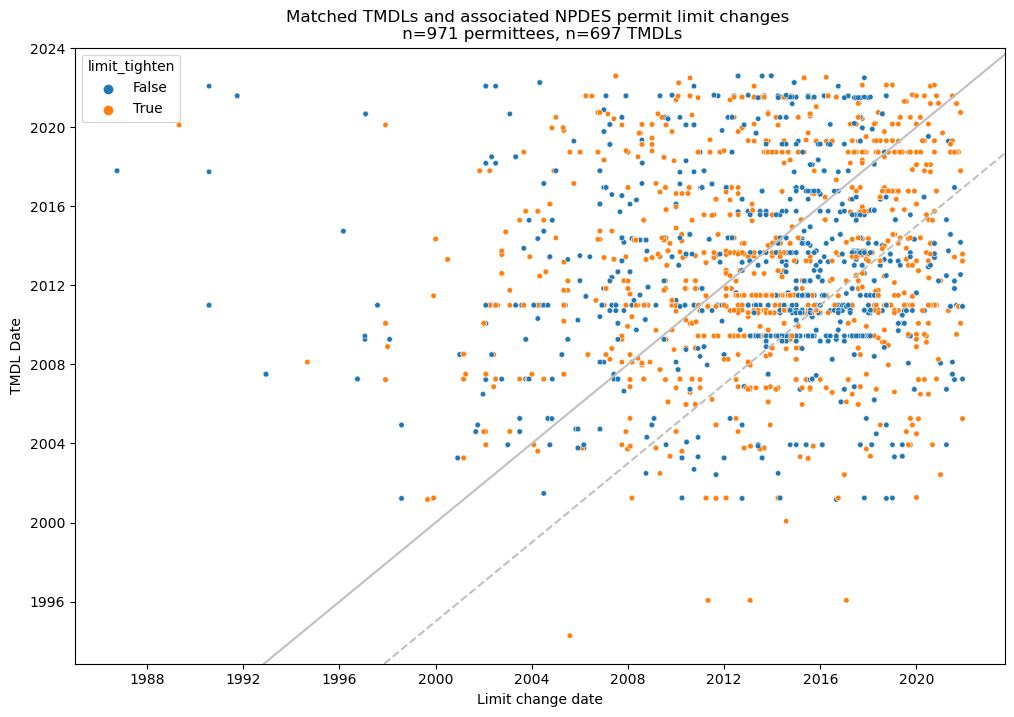

In [17]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('TMDL Date')
plt.xlabel('Limit change date')
sns.scatterplot(data=tmdls_limits_merged, x='limit_change_date', y='TMDLDate', hue='limit_tighten', s=15);

# Points on this line have limit change date = TMDL Date
plt.axline((dts.datestr2num('2012-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2012-01-02'), dts.datestr2num('2012-01-02')), color='silver')
# Line for 5-years post-TMDL
plt.axline((dts.datestr2num('2017-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2017-01-02'), dts.datestr2num('2012-01-02')), linestyle='--', label='5 years post-TMDL',
           color='silver')

plt.title('Matched TMDLs and associated NPDES permit limit changes \n n=' + str(
    len(tmdls_limits_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_limits_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs');

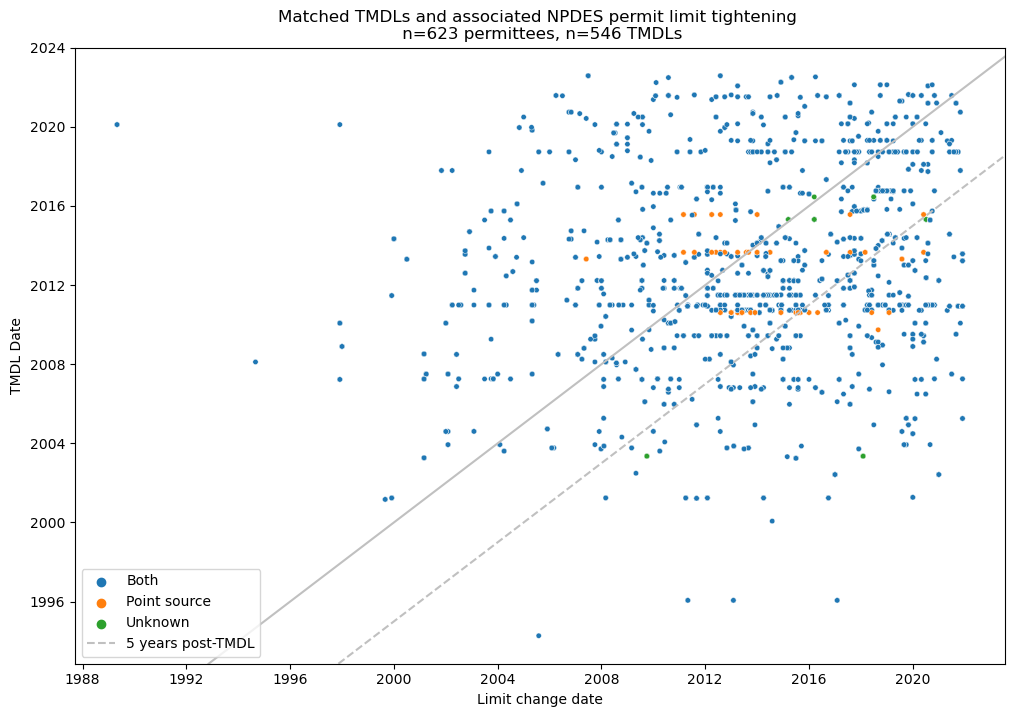

In [18]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('TMDL Date')
plt.xlabel('Limit change date')
sns.scatterplot(data=tmdls_limits_merged[tmdls_limits_merged['limit_tighten']], x='limit_change_date', y='TMDLDate',
                hue='pollutantSourceTypeCode', s=15);
plt.axline((dts.datestr2num('2012-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2012-01-02'), dts.datestr2num('2012-01-02')), color='silver')
plt.axline((dts.datestr2num('2017-01-01'), dts.datestr2num('2012-01-01')),
           (dts.datestr2num('2017-01-02'), dts.datestr2num('2012-01-02')), linestyle='--', label='5 years post-TMDL',
           color='silver')
plt.title('Matched TMDLs and associated NPDES permit limit tightening \n n=' + str(
    len(tmdls_limits_merged[tmdls_limits_merged['limit_tighten']].drop_duplicates(
        'npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_limits_merged[tmdls_limits_merged['limit_tighten']].drop_duplicates('actionIdentifier'))) + ' TMDLs');
plt.legend();

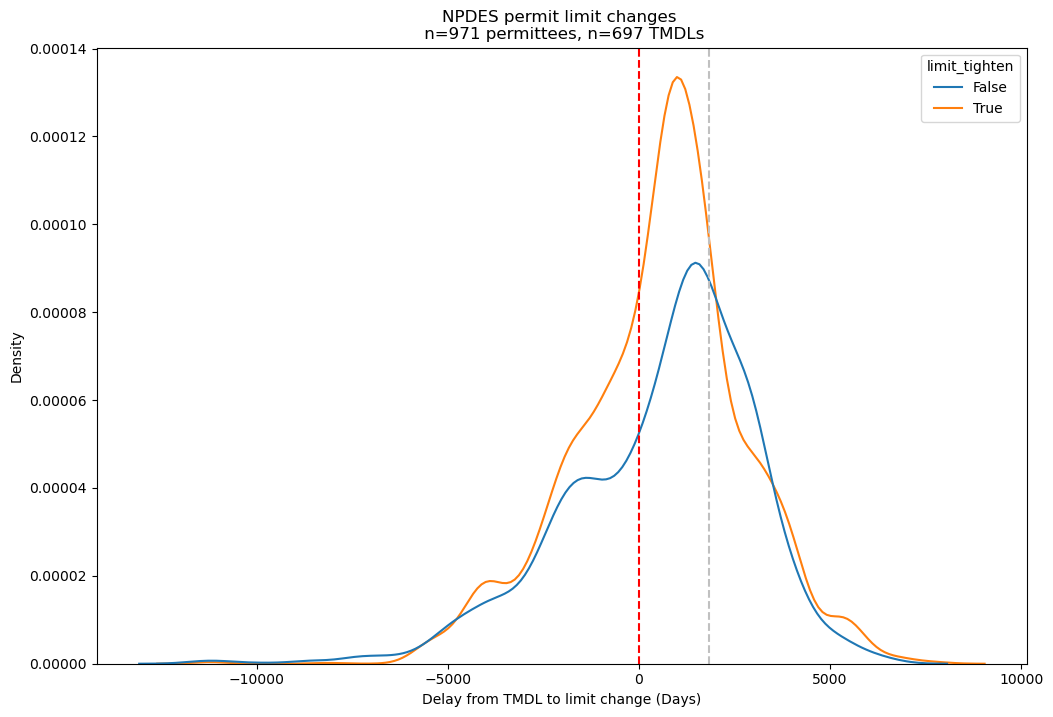

In [19]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Delay from TMDL to limit change (Days)')
sns.kdeplot(data=tmdls_limits_merged, x='limit_change_delay', hue='limit_tighten');
plt.axvline(x=365 * 5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('NPDES permit limit changes \n n=' + str(
    len(tmdls_limits_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_limits_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs');

In [20]:
print('Portion of limits tightened within 5 years post-TMDL:',
      round(tmdls_limits_merged[tmdls_limits_merged['limit_tighten']]['limit_change_within_5yrs'].mean(), 3), ' (n =',
      len(tmdls_limits_merged[
              (tmdls_limits_merged['limit_tighten']) & (tmdls_limits_merged['limit_change_within_5yrs'])]), ')')
print('Portion of limits tightened within 5 years pre-TMDL:',
      round(tmdls_limits_merged[tmdls_limits_merged['limit_tighten']]['limit_change_within_-5yrs'].mean(), 3), ' (n =',
      len(tmdls_limits_merged[
              (tmdls_limits_merged['limit_tighten']) & (tmdls_limits_merged['limit_change_within_-5yrs'])]), ')')

print('Portion of limits relaxed within 5 years post-TMDL:',
      round(tmdls_limits_merged[~tmdls_limits_merged['limit_tighten']]['limit_change_within_5yrs'].mean(), 3), ' (n =',
      len(tmdls_limits_merged[
              (~tmdls_limits_merged['limit_tighten']) & (tmdls_limits_merged['limit_change_within_5yrs'])]), ')')
print('Portion of limits relaxed within 5 years pre-TMDL:',
      round(tmdls_limits_merged[~tmdls_limits_merged['limit_tighten']]['limit_change_within_-5yrs'].mean(), 3), ' (n =',
      len(tmdls_limits_merged[
              (~tmdls_limits_merged['limit_tighten']) & (tmdls_limits_merged['limit_change_within_-5yrs'])]), ')')

Portion of limits tightened within 5 years post-TMDL: 0.419  (n = 1156 )
Portion of limits tightened within 5 years pre-TMDL: 0.209  (n = 576 )
Portion of limits relaxed within 5 years post-TMDL: 0.343  (n = 760 )
Portion of limits relaxed within 5 years pre-TMDL: 0.172  (n = 380 )


In [21]:
tmdls_limits_merged.groupby(['limit_tighten', 'pollutantSourceTypeCode']).agg(
    five_years_post_pct=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.mean() * 100),
    five_years_post_n=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.sum()),
    five_years_pre_pct=pd.NamedAgg(column='limit_change_within_-5yrs', aggfunc=lambda x: x.mean() * 100),
    five_years_pre_n=pd.NamedAgg(column='limit_change_within_-5yrs', aggfunc=lambda x: x.sum()))

five_years_post_pct  five_years_post_n  \
limit_tighten pollutantSourceTypeCode                                           
False         Both                               32.560341                688   
              Point source                       71.428571                 60   
              Unknown                            75.000000                 12   
True          Both                               41.572184               1100   
              Point source                       52.439024                 43   
              Unknown                            39.393939                 13   

                                       five_years_pre_pct  five_years_pre_n  
limit_tighten pollutantSourceTypeCode                                        
False         Both                              17.605301               372  
              Point source                       9.523810                 8  
              Unknown                            0.000000                 0  
True          Both                              20.710506               548  
              Point source                      29.268293                24  
              Unknown                           12.121212                 4

The following table looks just at limits tightened, broken down by state.

In [22]:
tmdls_limits_merged[tmdls_limits_merged['limit_tighten'] == True].groupby('state_code').agg(
    five_years_post_pct=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.mean() * 100),
    five_years_post_n_limit_tightens=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.sum()),
    five_years_pre_pct=pd.NamedAgg(column='limit_change_within_-5yrs', aggfunc=lambda x: x.mean() * 100),
    five_years_pre_n_limit_tightens=pd.NamedAgg(column='limit_change_within_-5yrs',
                                                aggfunc=lambda x: x.sum())).sort_values(
    by='five_years_post_n_limit_tightens', ascending=False)

,five_years_post_pct,five_years_post_n_limit_tightens,five_years_pre_pct,five_years_pre_n_limit_tightens
state_code,,,,
TX,75.073314,512,6.744868,46
WV,50.716332,177,16.905444,59
CA,38.328530,133,35.158501,122
PA,28.612717,99,20.809249,72
MI,35.000000,42,46.666667,56
MD,21.341463,35,20.731707,34
VA,21.739130,25,6.086957,7
FL,17.857143,20,30.357143,34
MT,33.333333,20,11.666667,7


The following table looks just at limits tightened, broken down by pollutant.

In [23]:
tmdls_limits_merged[tmdls_limits_merged['limit_tighten'] == True].groupby('pollutantName').agg(
    five_years_post_pct=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.mean()),
    five_years_post_n_limit_tightens=pd.NamedAgg(column='limit_change_within_5yrs', aggfunc=lambda x: x.sum()),
    five_years_pre_pct=pd.NamedAgg(column='limit_change_within_-5yrs', aggfunc=lambda x: x.mean()),
    five_years_pre_n_limit_tightens=pd.NamedAgg(column='limit_change_within_-5yrs',
                                                aggfunc=lambda x: x.sum())).sort_values(
    by='five_years_post_n_limit_tightens', ascending=False)

,five_years_post_pct,five_years_post_n_limit_tightens,five_years_pre_pct,five_years_pre_n_limit_tightens
pollutantName,,,,
ESCHERICHIA COLI (E. COLI),0.731915,516,0.080851,57
IRON,0.479167,184,0.148438,57
MERCURY,0.367347,72,0.387755,76
TOTAL SUSPENDED SOLIDS (TSS),0.262745,67,0.180392,46
"NITROGEN, TOTAL",0.260331,63,0.219008,53
SEDIMENT,0.199324,59,0.226351,67
COPPER,0.316176,43,0.389706,53
"PHOSPHORUS, TOTAL",0.254658,41,0.416149,67
SELENIUM,0.420290,29,0.289855,20


What if we break down by # permittees instead of # limits tightened?

In [24]:
tmdls_limits_merged.groupby(['limit_tighten', 'limit_change_within_5yrs', 'limit_change_within_-5yrs']).nunique()[
    ['npdes_permit_id']]

npdes_permit_id
limit_tighten limit_change_within_5yrs limit_change_within_-5yrs                 
False         False                    False                                  324
                                       True                                   139
              True                     False                                  223
True          False                    False                                  294
                                       True                                   193
              True                     False                                  289

In [25]:
print('Portion of permittees with limits tightened within 5 years post-TMDL:', round(
    tmdls_limits_merged[tmdls_limits_merged['limit_tighten']].drop_duplicates('npdes_permit_id')[
        'limit_change_within_5yrs'].mean(), 3), ' (n=', len(tmdls_limits_merged[tmdls_limits_merged['limit_tighten'] & (
tmdls_limits_merged['limit_change_within_5yrs'])].drop_duplicates('npdes_permit_id')), ')')
print('Portion of permittees with limits tightened within 5 years pre-TMDL:', round(
    tmdls_limits_merged[tmdls_limits_merged['limit_tighten']].drop_duplicates('npdes_permit_id')[
        'limit_change_within_-5yrs'].mean(), 3), ' (n=', len(tmdls_limits_merged[
                                                                 tmdls_limits_merged['limit_tighten'] & (
                                                                 tmdls_limits_merged[
                                                                     'limit_change_within_-5yrs'])].drop_duplicates(
    'npdes_permit_id')), ')')

print('Portion of permittees with limits relaxed within 5 years post-TMDL:', round(
    tmdls_limits_merged[~tmdls_limits_merged['limit_tighten']].drop_duplicates('npdes_permit_id')[
        'limit_change_within_5yrs'].mean(), 3), ' (n=', len(tmdls_limits_merged[
                                                                ~tmdls_limits_merged['limit_tighten'] & (
                                                                tmdls_limits_merged[
                                                                    'limit_change_within_5yrs'])].drop_duplicates(
    'npdes_permit_id')), ')')
print('Portion of permittees with limits relaxed within 5 years pre-TMDL:', round(
    tmdls_limits_merged[~tmdls_limits_merged['limit_tighten']].drop_duplicates('npdes_permit_id')[
        'limit_change_within_-5yrs'].mean(), 3), ' (n=', len(tmdls_limits_merged[
                                                                 ~tmdls_limits_merged['limit_tighten'] & (
                                                                 tmdls_limits_merged[
                                                                     'limit_change_within_-5yrs'])].drop_duplicates(
    'npdes_permit_id')), ')')

Portion of permittees with limits tightened within 5 years post-TMDL: 0.382  (n= 289 )
Portion of permittees with limits tightened within 5 years pre-TMDL: 0.238  (n= 193 )
Portion of permittees with limits relaxed within 5 years post-TMDL: 0.322  (n= 223 )
Portion of permittees with limits relaxed within 5 years pre-TMDL: 0.174  (n= 139 )


How do these results change if we only include TMDLs from 2013 or later?

In [26]:
subset = tmdls_limits_merged[tmdls_limits_merged['TMDLDate'] > pd.to_datetime('2013-01-01')]

print('Portion of permittees with limits tightened within 5 years post-TMDL:',
      round(subset[subset['limit_tighten']].drop_duplicates('npdes_permit_id')['limit_change_within_5yrs'].mean(), 3),
      ' (n=',
      len(subset[subset['limit_tighten'] & (subset['limit_change_within_5yrs'])].drop_duplicates('npdes_permit_id')),
      ')')
print('Portion of permittees with limits tightened within 5 years pre-TMDL:',
      round(subset[subset['limit_tighten']].drop_duplicates('npdes_permit_id')['limit_change_within_-5yrs'].mean(), 3),
      ' (n=',
      len(subset[subset['limit_tighten'] & (subset['limit_change_within_-5yrs'])].drop_duplicates('npdes_permit_id')),
      ')')

print('Portion of permittees with limits relaxed within 5 years post-TMDL:',
      round(subset[~subset['limit_tighten']].drop_duplicates('npdes_permit_id')['limit_change_within_5yrs'].mean(), 3),
      ' (n=',
      len(subset[~subset['limit_tighten'] & (subset['limit_change_within_5yrs'])].drop_duplicates('npdes_permit_id')),
      ')')
print('Portion of permittees with limits relaxed within 5 years pre-TMDL:',
      round(subset[~subset['limit_tighten']].drop_duplicates('npdes_permit_id')['limit_change_within_-5yrs'].mean(), 3),
      ' (n=',
      len(subset[~subset['limit_tighten'] & (subset['limit_change_within_-5yrs'])].drop_duplicates('npdes_permit_id')),
      ')')

Portion of permittees with limits tightened within 5 years post-TMDL: 0.299  (n= 124 )
Portion of permittees with limits tightened within 5 years pre-TMDL: 0.344  (n= 145 )
Portion of permittees with limits relaxed within 5 years post-TMDL: 0.245  (n= 89 )
Portion of permittees with limits relaxed within 5 years pre-TMDL: 0.344  (n= 96 )


What is the overall distribution of TMDL Dates and Limit Change dates?

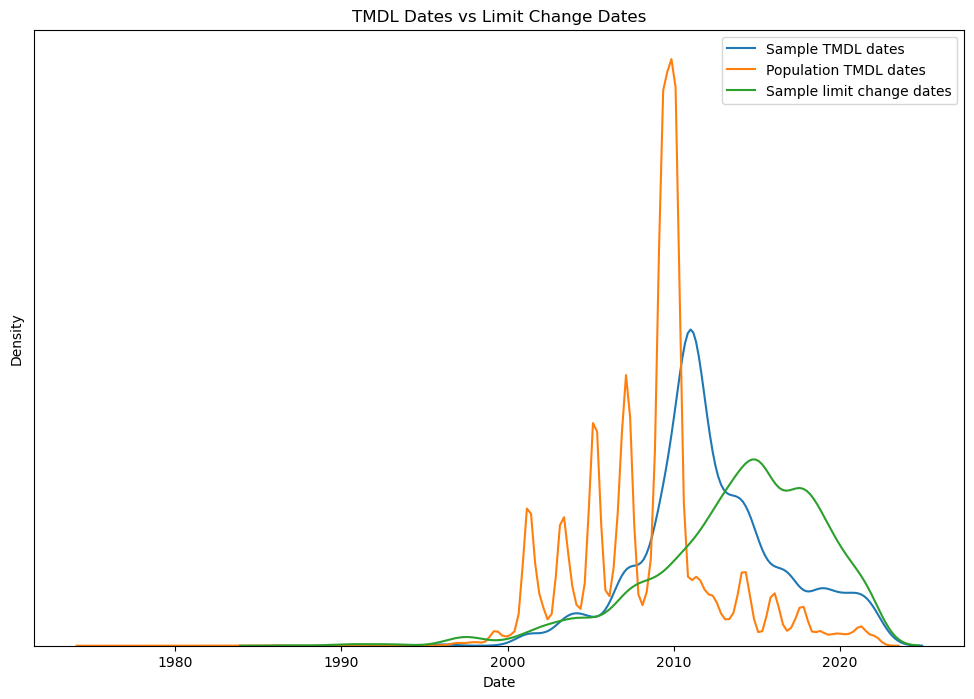

In [27]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Date')
plt.yticks([])
sns.kdeplot(data=tmdls_limits_merged, x='TMDLDate', label='Sample TMDL dates');
sns.kdeplot(data=tmdls, x='TMDLDate', label='Population TMDL dates');
sns.kdeplot(data=tmdls_limits_merged, x='limit_change_date', label='Sample limit change dates');
plt.title('TMDL Dates vs Limit Change Dates');
plt.legend();

What is the background pattern in limit changes among NPDES permittees that we can't link to TMDLs?

In [28]:
npdes_linked = list(tmdls_limits_merged['npdes_permit_id'].unique())

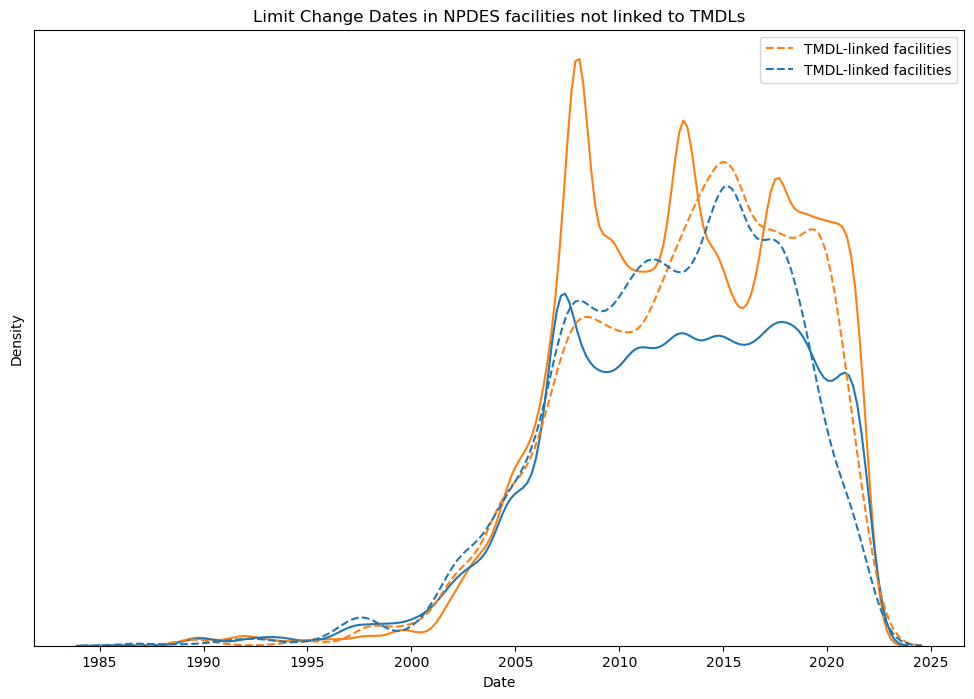

In [29]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Date')
plt.yticks([])
sns.kdeplot(data=limit_changes[limit_changes['npdes_permit_id'].apply(lambda x: x not in npdes_linked)],
            x='limit_change_date', hue='limit_tighten');
sns.kdeplot(data=limit_changes[limit_changes['npdes_permit_id'].apply(lambda x: x in npdes_linked)],
            x='limit_change_date', hue='limit_tighten', linestyle='--', label='TMDL-linked facilities');
plt.title('Limit Change Dates in NPDES facilities not linked to TMDLs');
plt.legend();

To analyze background rates of new limits (not just limit changes), we need to load in DMR data reduced to the limit level. Here, a 'new limit' is uniquely defined by limit identifying variables (npdes_permit_id, perm_feature_nmbr (outfall), parameter_desc, limit_value_type_code, statistical_base_code) plus a limit_begin_date.

In [30]:
# Set states
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY_pre-2010',
          'KY_2010-2019', 'KY_post-2019', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
          'NM', 'NY', 'NC', 'ND', 'OH_pre-2010', 'OH_post-2010', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
          'VT', 'VA', 'WA', 'WV_pre-2010', 'WV_2010-2015', 'WV_2015-2018', 'WV_2018-2020', 'WV_post-2020', 'WI', 'WY']
limits_all = pd.DataFrame()
for state in states:
    state_limits = pd.read_csv(
        '/Users/rtreves/Documents/RegLab/python_projects/dmr_permit_limit_changes/dmr_data/' + state + '_limit_dates.csv',
        parse_dates=['limit_begin_date'],
        date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

    limits_all = pd.concat([limits_all, state_limits], axis=0, ignore_index=True)
    print(state + ' Done')
    del state_limits

AL Done
AK Done
AZ Done
AR Done
CA Done
CO Done
CT Done
DE Done
FL Done
GA Done
HI Done
ID Done
IL Done
IN Done
IA Done
KS Done
KY_pre-2010 Done
KY_2010-2019 Done
KY_post-2019 Done
LA Done
MA Done
MD Done
ME Done
MI Done
MN Done
MS Done
MO Done
MT Done
NE Done
NV Done
NH Done
NJ Done
NM Done
NY Done
NC Done
ND Done
OH_pre-2010 Done
OH_post-2010 Done
OK Done
OR Done
PA Done
RI Done
SC Done
SD Done
TN Done
TX Done
UT Done
VT Done
VA Done
WA Done
WV_pre-2010 Done
WV_2010-2015 Done
WV_2015-2018 Done
WV_2018-2020 Done
WV_post-2020 Done
WI Done
WY Done


In [31]:
# Add a flag to limits based on whether permittee is linked to a TMDL
limits_all['linked_to_TMDL'] = limits_all['npdes_permit_id'].apply(lambda x: x in npdes_linked)

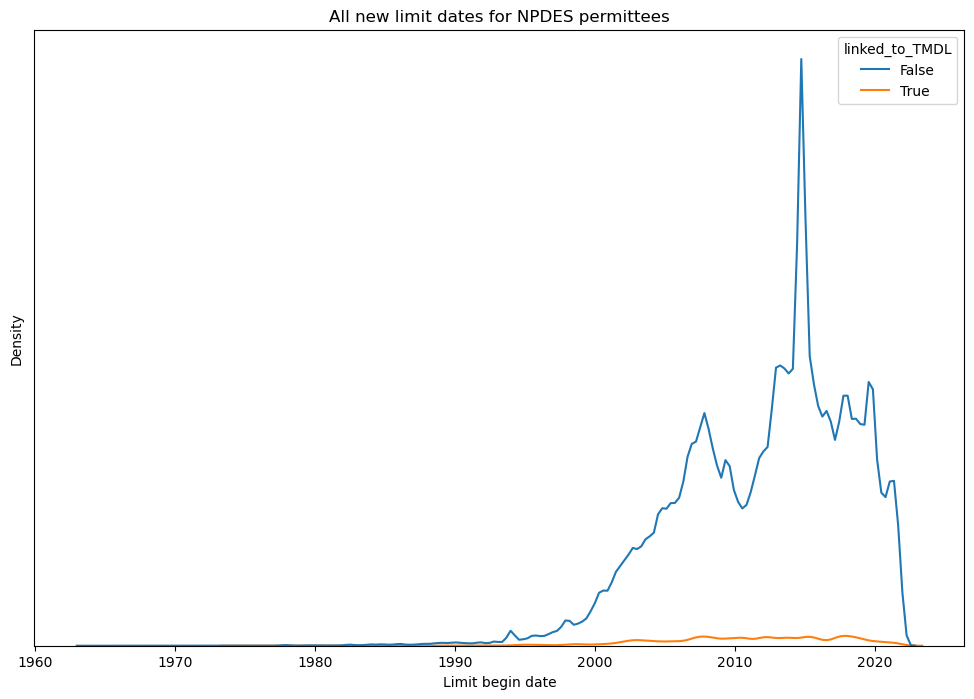

In [32]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Limit begin date')
plt.yticks([])
sns.kdeplot(data=limits_all, hue='linked_to_TMDL', x='limit_begin_date');
plt.title('All new limit dates for NPDES permittees');

In [33]:
# Now let's add the same flag to our list of limit changes
limit_changes['linked_to_TMDL'] = limit_changes['npdes_permit_id'].apply(lambda x: x in npdes_linked)

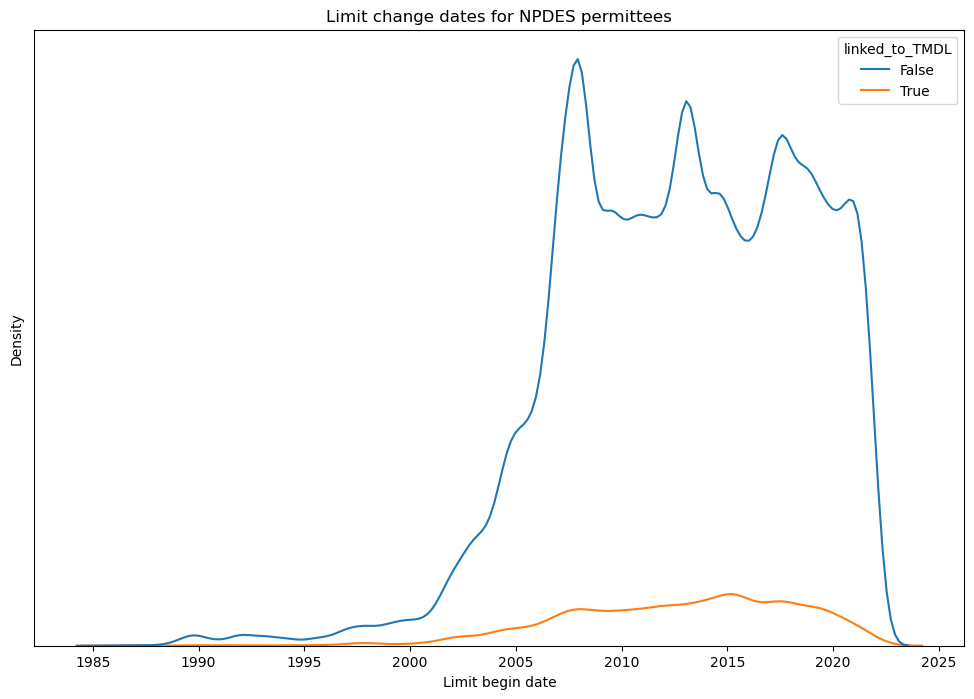

In [34]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Limit begin date')
plt.yticks([])
sns.kdeplot(data=limit_changes, hue='linked_to_TMDL', x='limit_change_date');
plt.title('Limit change dates for NPDES permittees');

In [35]:
pd.DataFrame(
    data={'New limits': [len(limits_all[limits_all['linked_to_TMDL']]), len(limits_all[~limits_all['linked_to_TMDL']])],
          'Limits changed': [len(limit_changes[limit_changes['linked_to_TMDL']]),
                             len(limit_changes[~limit_changes['linked_to_TMDL']])],
          'Limits tightened': [len(limit_changes[(limit_changes['linked_to_TMDL']) & (limit_changes['limit_tighten'])]),
                               len(limit_changes[
                                       (~limit_changes['linked_to_TMDL']) & (limit_changes['limit_tighten'])])],
          'Limits relaxed': [len(limit_changes[(limit_changes['linked_to_TMDL']) & (~limit_changes['limit_tighten'])]),
                             len(limit_changes[
                                     (~limit_changes['linked_to_TMDL']) & (~limit_changes['limit_tighten'])])]},
    index=['Permittees linked to TMDLs', 'Permittees not linked to TMDLs'])

,New limits,Limits changed,Limits tightened,Limits relaxed
Permittees linked to TMDLs,409702,17502,8991,8511
Permittees not linked to TMDLs,12145629,209066,119641,89425


Tightened limits represent .99%, and relaxed limits represent 0.74%, of all new limits issued to NPDES permittees not linked to TMDLs.
Tightened limits represent 2.2%, and relaxed limits represent 2.1%, of all new limits issued to NPDES permittees linked to TMDLs.